In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import os
# os.environ['USE_PYGEOS'] = '0'
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
# import constants as c
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

In [5]:
scenario_name = 'BayArea'
input_dir = 'inputs_' + scenario_name
output_dir = 'outputs_' + scenario_name
plot_dir = 'plots_' + scenario_name
# region_code = [411, 531, 532, 539]
region_code = [62, 64, 65, 69]
focus_region = 64

map_file = scenario_name + '_freight_centroids.geojson'
region_map = gpd.read_file(os.path.join(input_dir, map_file))
region_map.head(5)

,GEOID,CBPZONE,MESOZONE,geometry
0,060014514011,6001,1011.0,POINT (-121.77842 37.69647)
1,060014419232,6001,844.0,POINT (-121.98422 37.54955)
2,060855083011,6085,8270.0,POINT (-122.06205 37.34504)
3,060190018004,6019,2177.0,POINT (-119.79820 36.65184)
4,061070022021,6107,10242.0,POINT (-119.35129 36.20861)


In [18]:

truck_mode = ['For-hire Truck', 'Private Truck']
naics_code = '212230'
# naics_code = '335911'
# look up table for sctg group and label
# print(sctg_group_short)
# sctg_def = {'sctg1': 'bulk', 'sctg2': 'fuel_fert', 'sctg3':'interm_food', 'sctg4': 'mfr_goods', 'sctg5': 'other'}
# <codecell>
combined_modeled_OD = None
combined_modeled_OD_mesozone = None
# mode_choide_by_commodity = None
# combined_truck_output = None
for k in range(5):
    sctg = 'sctg' + str(k + 1)
    print('post process mode choice results from ' + sctg)
    b2b_dir = os.path.join(output_dir, sctg)
    list_of_b2b_files = [f for f in os.listdir(b2b_dir) if f.endswith('.zip')]
    iterator = 0
#     cut_off_point = max_ton_lookup[sctg] # shipment capacity for this shipment
    for file in list_of_b2b_files:
        if file == '.DS_Store':
            continue
        # if iterator%10 == 0:
        #     print(iterator)
        modeled_OD_by_sctg = read_csv(os.path.join(b2b_dir, file), sep = ',')
#         print(modeled_OD_by_sctg.columns)
        list_of_var = ['BuyerID', 'BuyerZone', 'BuyerNAICS', 'SellerID',
           'SellerZone', 'SellerNAICS', 'TruckLoad', 'Commodity_SCTG', 'SCTG_Group', 
           'shipment_id', 'orig_FAFID', 'dest_FAFID', 
           'mode_choice', 'probability', 'Distance', 'Travel_time']
#         print(modeled_OD_by_sctg.head(5))
       
        int_var = ['BuyerID', 'BuyerZone', 'SellerID',
           'SellerZone', 'Commodity_SCTG', 'SCTG_Group', 
           'shipment_id', 'orig_FAFID', 'dest_FAFID']
        # print(modeled_OD_by_sctg['BuyerNAICS'].unique())
        modeled_OD_by_sctg['SellerNAICS'] = \
        modeled_OD_by_sctg['SellerNAICS'].astype(str)
        modeled_OD_by_sctg = \
        modeled_OD_by_sctg.loc[modeled_OD_by_sctg['SellerNAICS'] == naics_code] 
        if len(modeled_OD_by_sctg) > 0:
            print('found industry '+ naics_code)
        ## compute national shipment count and tonmile
        modeled_OD_by_sctg['ShipmentLoad'] = modeled_OD_by_sctg['TruckLoad'] / 1000 # convert to thousand tons
        combined_modeled_OD = pd.concat([combined_modeled_OD,
                                         modeled_OD_by_sctg])
    #     break
    # break    

post process mode choice results from sctg1
found industry 212230
post process mode choice results from sctg2
post process mode choice results from sctg3
post process mode choice results from sctg4
post process mode choice results from sctg5


In [19]:
# combined_modeled_OD = \
# combined_modeled_OD.loc[combined_modeled_OD['orig_FAFID'] == focus_region]
print(len(combined_modeled_OD))
combined_modeled_OD.head(5)

27527


,Unnamed: 0,BuyerID,BuyerZone,BuyerNAICS,SellerID,SellerZone,SellerNAICS,TruckLoad,Commodity_SCTG,SCTG_Group,NAICS_code,shipment_id,orig_FAFID,dest_FAFID,mode_choice,probability,Distance,Travel_time,ShipmentLoad
642668,642668,8359941.0,9621.0,713900,27801.0,20007.0,212230,24.284982,14.0,1.0,21.0,642669.0,49.0,64.0,For-hire Truck,0.716876,1052.69,43.702368,0.024285
642669,642669,8359941.0,9621.0,713900,27801.0,20007.0,212230,24.284982,14.0,1.0,21.0,642670.0,49.0,64.0,For-hire Truck,0.716876,1052.69,43.702368,0.024285
642670,642670,8359941.0,9621.0,713900,27801.0,20007.0,212230,24.284982,14.0,1.0,21.0,642671.0,49.0,64.0,For-hire Truck,0.716876,1052.69,43.702368,0.024285
642671,642671,8359941.0,9621.0,713900,27801.0,20007.0,212230,24.284982,14.0,1.0,21.0,642672.0,49.0,64.0,For-hire Truck,0.716876,1052.69,43.702368,0.024285
642672,642672,8359941.0,9621.0,713900,27801.0,20007.0,212230,24.284982,14.0,1.0,21.0,642673.0,49.0,64.0,For-hire Truck,0.716876,1052.69,43.702368,0.024285


In [20]:
group_var = ['BuyerZone', 'SellerZone', 'BuyerNAICS', 'SellerNAICS']
aggregated_flow = combined_modeled_OD.groupby(group_var)[['TruckLoad']].sum()
aggregated_flow= aggregated_flow.reset_index()
aggregated_flow[['BuyerZone', 'SellerZone']] = \
aggregated_flow[['BuyerZone', 'SellerZone']].astype(int)

aggregated_flow[['BuyerNAICS', 'SellerNAICS']] = \
aggregated_flow[['BuyerNAICS', 'SellerNAICS']].astype(str)
print(len(aggregated_flow))
aggregated_flow.head(5)

769


,BuyerZone,SellerZone,BuyerNAICS,SellerNAICS,TruckLoad
0,6,20007,812100,212230,122.2265
1,16,20006,611B00,212230,230.0865
2,22,20006,713900,212230,224.6225
3,25,20007,812100,212230,122.2265
4,44,20007,813A00,212230,1276.1035


In [21]:
# create flow lines
region_map['MESOZONE'] = region_map['MESOZONE'].astype(int)
aggregated_flow_with_od = pd.merge(aggregated_flow,
                                  region_map, 
                                   left_on = 'BuyerZone',
                                  right_on = 'MESOZONE',
                                  how = 'left')
aggregated_flow_with_od.rename(columns = {'geometry': 'to_point'}, 
                               inplace = True)

aggregated_flow_with_od = pd.merge(aggregated_flow_with_od,
                                  region_map, 
                                   left_on = 'SellerZone',
                                  right_on = 'MESOZONE',
                                  how = 'left')
aggregated_flow_with_od.rename(columns = {'geometry': 'fr_point'}, 
                               inplace = True)
aggregated_flow_with_od.head(5)

,BuyerZone,SellerZone,BuyerNAICS,SellerNAICS,TruckLoad,GEOID_x,CBPZONE_x,MESOZONE_x,to_point,GEOID_y,CBPZONE_y,MESOZONE_y,fr_point
0,6,20007,812100,212230,122.2265,060014003003,6001,6,POINT (-122.25967 37.84047),49,7,20007,POINT (-111.59001 34.71624)
1,16,20006,611B00,212230,230.0865,060014007001,6001,16,POINT (-122.27345 37.84544),42,6,20006,POINT (-111.67670 32.03137)
2,22,20006,713900,212230,224.6225,060014008003,6001,22,POINT (-122.28247 37.84276),42,6,20006,POINT (-111.67670 32.03137)
3,25,20007,812100,212230,122.2265,060014010001,6001,25,POINT (-122.26971 37.83587),49,7,20007,POINT (-111.59001 34.71624)
4,44,20007,813A00,212230,1276.1035,060014015001,6001,44,POINT (-122.28022 37.82525),49,7,20007,POINT (-111.59001 34.71624)


<Axes: >

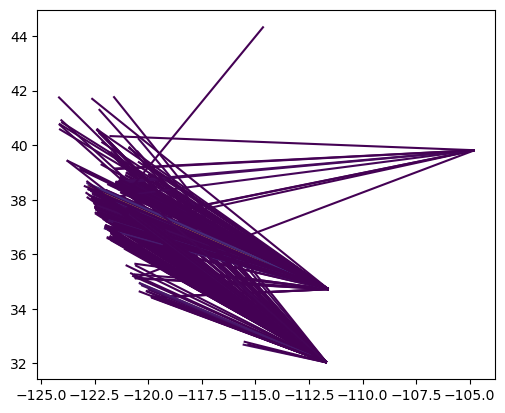

In [22]:
from shapely.geometry import LineString

aggregated_flow_with_od['geometry'] = \
aggregated_flow_with_od.apply(lambda row: LineString([row['fr_point'], 
                                                      row['to_point']]), axis=1) #Create a linestring column
aggregated_flow_with_od = gpd.GeoDataFrame(aggregated_flow_with_od, 
                                           crs="EPSG:4326") 
aggregated_flow_with_od.plot(column = 'TruckLoad')

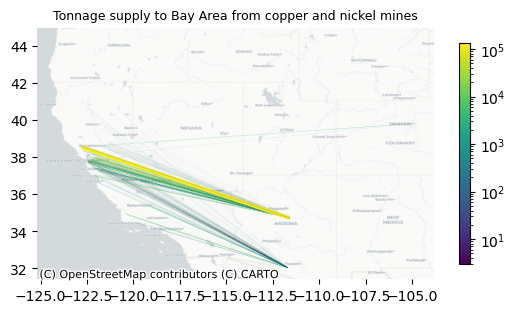

In [33]:
industry_name_lookup = {'212230': 'copper and nickel mines',
                       '335911': 'Storage Battery Manufacturing'}
import matplotlib
ind_name = industry_name_lookup[naics_code]
ax = aggregated_flow_with_od.plot(column = 'TruckLoad', legend=True,
                                 linewidth= 0.00002 * aggregated_flow_with_od['TruckLoad'],
                                 legend_kwds = {'shrink': 0.6},
                                 norm=matplotlib.colors.LogNorm(vmin=aggregated_flow_with_od['TruckLoad'].min(),
                                                                vmax=aggregated_flow_with_od['TruckLoad'].max()))
cx.add_basemap(ax, crs = 'EPSG:4326', source = cx.providers.CartoDB.Positron)
ax.grid(False)
plt.title('Tonnage supply to Bay Area from ' + ind_name, fontsize= 9)
plt.box(False)
plt.savefig(os.path.join(plot_dir, 'supply_chain_map_' + naics_code + '.png'), dpi = 300,
            bbox_inches = 'tight')